In [1]:
%matplotlib inline
import requests
import xml.etree.ElementTree as ET
import os
import pandas as pd

In [28]:
#データフレーム作成
pitchDF = pd.DataFrame(columns = ['pitchIdx','inning','frame','ab','abIdx','battter','stand','speed', \
                                  'pitchtype', 'px', 'pz', 'szTop', 'szBottom', 'des'], dtype=object)


In [4]:
#球種辞書作成
pitchDictionary = { "FA":"fastball", "FF":"4-seam fb", "FT": "2-seam fb", "FC": "fb-cutter", "":"unknown", None: "none", \
                    "FS":"fb-splitter", "SL":"slider", "CH":"changeup","CU":"curveball","KC":"knuckle-curve", \
                    "KN":"knuckleball","EP":"eephus", "UN":"unidentified", "PO":"pitchout", "SI":"sinker", "SF":"split-finger" \
                    }

frames = ['top','bottom']

In [5]:
# MLB Advanced Mediaが配信しているプレイヤー情報を読み込み
url = 'https://gd2.mlb.com/components/game/mlb/year_2014/month_06/day_18/gid_2014_06_18_colmlb_lanmlb_1/players.xml'
resp = requests.get(url) 
xmlfile = 'myplayers.xml'

with open(xmlfile, mode='wb') as f:
    f.write(resp.content)
statinfo = os.stat(xmlfile)

In [19]:
#xmlファイルを解析
tree = ET.parse(xmlfile)
game = tree.getroot()
teams = game.findall('./team')

playerDict = {}

#選手情報の取得
for team in teams:
    players = team.findall('./player')
    for player in players:
        playerDict[player.attrib.get('id')] = player.attrib.get('first') + ' ' + player.attrib.get('last')

In [29]:
# MLB Advanced Mediaが配信しているイニング毎のデータを読み込み
url = 'https://gd2.mlb.com/components/game/mlb/year_2014/month_06/day_18/gid_2014_06_18_colmlb_lanmlb_1/inning/inning_all.xml'
resp = requests.get(url)
xmlfile = 'mygame.xml'

with open(xmlfile, mode='wb') as f:
    f.write(resp.content)
statinfo = os.stat(xmlfile)

tree = ET.parse(xmlfile)
root = tree.getroot()
innings = root.findall('./inning')

totalPitchCount = 0
topPitchCount = 0
bottomPitchCount = 0

for inning in innings:
    
    for i in range(len(frames)):
        fr = inning.find(frames[i])
        
        if fr is not None:
            for ab in fr.iter('atbat'):
                battername = playerDict[ab.get('batter')]
                standside = ab.get('stand')
                abIdx = ab.get('num')
                abPitchCount = 0
                
                pitches = ab.findall('pitch')
                for pitch in pitches:
                    if pitch.attrib.get('start_speed') is None:
                        speed = 0
                    else:
                        speed = float(pitch.attrib.get('start_speed'))
                    
                    pxFloat = 0.0 if pitch.attrib.get('px') == None else float('{0:.2f}'.format(float(pitch.attrib.get("px"))))
                    pzFloat = 0.0 if pitch.attrib.get("pz") == None else float('{0:.2f}'.format(float(pitch.attrib.get("pz"))))
                    szTop = 0.0 if pitch.attrib.get("sz_top") == None else float('{0:.2f}'.format(float(pitch.attrib.get("sz_top"))))
                    szBot = 0.0 if pitch.attrib.get("sz_bot") == None else float('{0:.2f}'.format(float(pitch.attrib.get("sz_bot"))))
                    
                    abPitchCount = abPitchCount + 1
                    totalPitchCount = totalPitchCount + 1
                    
                    if frames[i] == 'top':
                        topPitchCount = topPitchCount + 1
                    else:
                        bottomPitchCount = bottomPitchCount + 1
                    
                    inn = inning.attrib.get('num')
                    verbosePitch = pitchDictionary[pitch.get('pitch_type')]
                    desPitch = pitch.get('des')
                    
                    # データフレームに追加
                    pitchDF.loc[totalPitchCount] = [float(totalPitchCount), inn, frames[i], abIdx, abPitchCount, battername, standside, speed, \
                                               verbosePitch, pxFloat, pzFloat, szTop, szBot, desPitch]
                    

In [30]:
pitchDF

,pitchIdx,inning,frame,ab,abIdx,battter,stand,speed,pitchtype,px,pz,szTop,szBottom,des
1,1.0,1,top,1,1,Corey Dickerson,L,93.3,4-seam fb,-0.52,1.86,3.40,1.51,Foul
2,2.0,1,top,1,2,Corey Dickerson,L,93.3,4-seam fb,-0.37,2.75,3.40,1.51,Swinging Strike
3,3.0,1,top,1,3,Corey Dickerson,L,94.6,4-seam fb,-1.67,1.33,3.66,1.71,Ball
4,4.0,1,top,1,4,Corey Dickerson,L,90.5,slider,-2.00,0.36,3.53,1.58,Ball
5,5.0,1,top,1,5,Corey Dickerson,L,93.8,4-seam fb,-0.26,3.47,3.40,1.51,Foul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,253.0,9,top,64,1,Charlie Culberson,R,93.7,4-seam fb,-0.25,2.05,3.32,1.54,"In play, out(s)"
254,254.0,9,top,65,1,Corey Dickerson,L,94.3,4-seam fb,0.65,3.06,3.40,1.51,Swinging Strike
255,255.0,9,top,65,2,Corey Dickerson,L,94.5,4-seam fb,0.00,4.02,3.40,1.51,Foul
256,256.0,9,top,65,3,Corey Dickerson,L,73.6,curveball,0.37,2.89,3.40,1.51,Foul


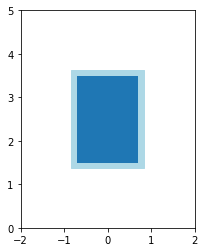

In [46]:
#ストライクゾーン作成
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')

# ストライクゾーン横幅は17インチ = 1.4フィート
# ストライクゾーン縦幅は1.5～3.5フィート
# 野球ボールのサイズは3インチ = 0.25フィート
# フィートの求め方 = インチ / 12
platewidthInFeet = 17/12
szHeightInFeet = 3.5 - 1.5

# ボール一個分外のストライクゾーン作成
# ライトブルーのフレームはボール一個分外のストライクゾーン
expandedPlateInFeet = 20 / 12
ballInFeet = 3 / 12
halfBallInFeet = ballInFeet / 2

ax1.add_patch(patches.Rectangle((expandedPlateInFeet/-2, 1.5 - halfBallInFeet), expandedPlateInFeet, szHeightInFeet + ballInFeet, color = 'lightblue'))
ax1.add_patch(patches.Rectangle((platewidthInFeet/-2, 1.5), platewidthInFeet, szHeightInFeet))

plt.ylim(0, 5)
plt.xlim(-2, 2)
plt.show()


In [50]:
#データフレームにストライク・ボール判定を追加
uniqDesList = pitchDF.des.unique()
ballCallList = []
strikeCallList = []
ballCount = 0
strikeCount = 0

for index, row in pitchDF.iterrows():
    des = row['des']
    if row['abIdx'] == 1:
        ballCount = 0
        strikeCount = 0
        
    ballCallList.append(ballCount)
    strikeCallList.append(strikeCount)
    
    if 'Ball' in des:
        ballCount = ballCount + 1
    elif 'Foul' in des:
        if strikeCount is not 2:
            strikeCount = strikeCount + 1
    elif 'Strike' in des:
        strikeCount = strikeCount + 1

pitchDF['ballCount'] = ballCallList
pitchDF['strikeCount'] = strikeCallList

In [51]:
pitchDF

,pitchIdx,inning,frame,ab,abIdx,battter,stand,speed,pitchtype,px,pz,szTop,szBottom,des,ballCount,strikeCount
1,1.0,1,top,1,1,Corey Dickerson,L,93.3,4-seam fb,-0.52,1.86,3.40,1.51,Foul,0,0
2,2.0,1,top,1,2,Corey Dickerson,L,93.3,4-seam fb,-0.37,2.75,3.40,1.51,Swinging Strike,0,1
3,3.0,1,top,1,3,Corey Dickerson,L,94.6,4-seam fb,-1.67,1.33,3.66,1.71,Ball,0,2
4,4.0,1,top,1,4,Corey Dickerson,L,90.5,slider,-2.00,0.36,3.53,1.58,Ball,1,2
5,5.0,1,top,1,5,Corey Dickerson,L,93.8,4-seam fb,-0.26,3.47,3.40,1.51,Foul,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,253.0,9,top,64,1,Charlie Culberson,R,93.7,4-seam fb,-0.25,2.05,3.32,1.54,"In play, out(s)",0,0
254,254.0,9,top,65,1,Corey Dickerson,L,94.3,4-seam fb,0.65,3.06,3.40,1.51,Swinging Strike,0,0
255,255.0,9,top,65,2,Corey Dickerson,L,94.5,4-seam fb,0.00,4.02,3.40,1.51,Foul,0,1
256,256.0,9,top,65,3,Corey Dickerson,L,73.6,curveball,0.37,2.89,3.40,1.51,Foul,0,2


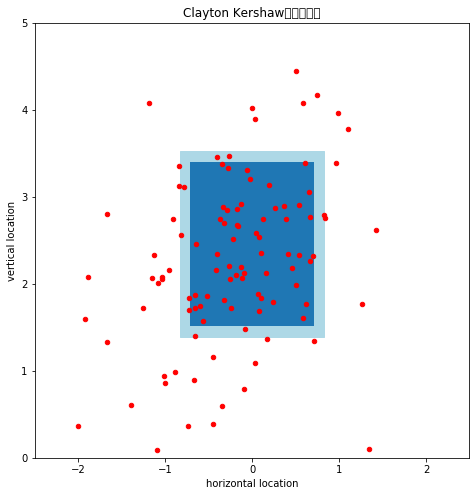

In [54]:
#Clayton Kershawの投球傾向
df = pitchDF[pitchDF['frame']=='top']

ax1 = df.plot(kind='scatter', x='px', y='pz', marker='o', color='red', figsize=[8,8], ylim=[0,4], xlim=[-2,2])
ax1.set_xlabel('horizontal location')
ax1.set_ylabel('vertical location')
ax1.set_title('Clayton Kershawの投球傾向')
ax1.set_aspect(aspect=1)

platewidthInFeet = 17 / 12
expandedPlateInFeet = 20 / 12
szTop = df['szTop'].iloc[0]
szBottom = df['szBottom'].iloc[0]
szHeightInFeet = szTop - szBottom
ballInFeet = 3 / 12
halfBallInFeet = ballInFeet / 2

outrect = ax1.add_patch(patches.Rectangle((expandedPlateInFeet/-2, szBottom - halfBallInFeet),expandedPlateInFeet, szHeightInFeet + ballInFeet, color='lightblue'))
rect = ax1.add_patch(patches.Rectangle((platewidthInFeet/-2, szBottom), platewidthInFeet, szHeightInFeet))
outrect.zorder=-2 
rect.zorder=-1 

plt.ylim(0, 5)
plt.xlim(-2.5, 2.5)
plt.show()

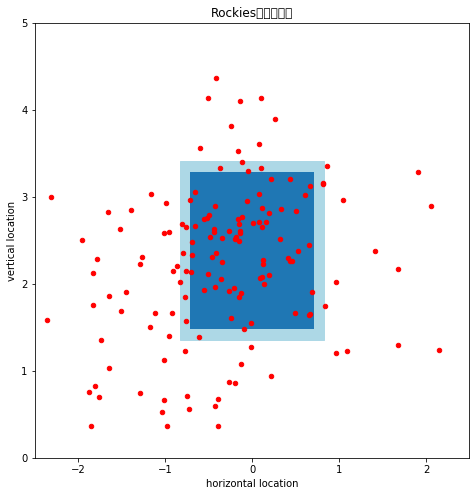

In [55]:
#Rockiesの投球傾向
df = pitchDF[pitchDF['frame']=='bottom']

ax1 = df.plot(kind='scatter', x='px', y='pz', marker='o', color='red', figsize=[8,8], ylim=[0,4], xlim=[-2,2])
ax1.set_xlabel('horizontal location')
ax1.set_ylabel('vertical location')
ax1.set_title('Rockiesの投球傾向')
ax1.set_aspect(aspect=1)

platewidthInFeet = 17 / 12
expandedPlateInFeet = 20 / 12
szTop = df['szTop'].iloc[0]
szBottom = df['szBottom'].iloc[0]
szHeightInFeet = szTop - szBottom
ballInFeet = 3 / 12
halfBallInFeet = ballInFeet / 2

outrect = ax1.add_patch(patches.Rectangle((expandedPlateInFeet/-2, szBottom - halfBallInFeet),expandedPlateInFeet, szHeightInFeet + ballInFeet, color='lightblue'))
rect = ax1.add_patch(patches.Rectangle((platewidthInFeet/-2, szBottom), platewidthInFeet, szHeightInFeet))
outrect.zorder=-2 
rect.zorder=-1 

plt.ylim(0, 5)
plt.xlim(-2.5, 2.5)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21021 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 21021 missing from current font.
  font.set_text(s, 0, flags=flags)


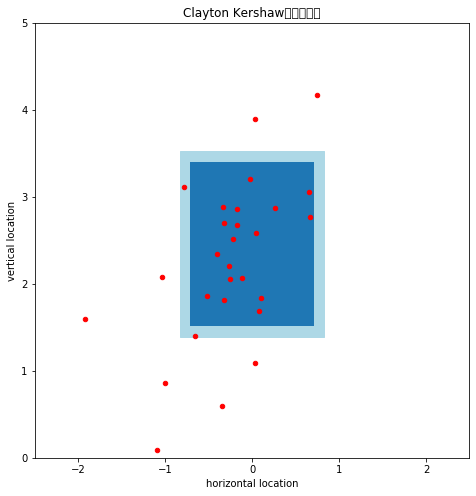

In [56]:
#Clayton Kershawの投球傾向
df = pitchDF[pitchDF['frame']=='top'][pitchDF['abIdx'] == 1]

ax1 = df.plot(kind='scatter', x='px', y='pz', marker='o', color='red', figsize=[8,8], ylim=[0,4], xlim=[-2,2])
ax1.set_xlabel('horizontal location')
ax1.set_ylabel('vertical location')
ax1.set_title('Clayton Kershawの初球傾向')
ax1.set_aspect(aspect=1)

platewidthInFeet = 17 / 12
expandedPlateInFeet = 20 / 12
szTop = df['szTop'].iloc[0]
szBottom = df['szBottom'].iloc[0]
szHeightInFeet = szTop - szBottom
ballInFeet = 3 / 12
halfBallInFeet = ballInFeet / 2

outrect = ax1.add_patch(patches.Rectangle((expandedPlateInFeet/-2, szBottom - halfBallInFeet),expandedPlateInFeet, szHeightInFeet + ballInFeet, color='lightblue'))
rect = ax1.add_patch(patches.Rectangle((platewidthInFeet/-2, szBottom), platewidthInFeet, szHeightInFeet))
outrect.zorder=-2 
rect.zorder=-1 

plt.ylim(0, 5)
plt.xlim(-2.5, 2.5)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


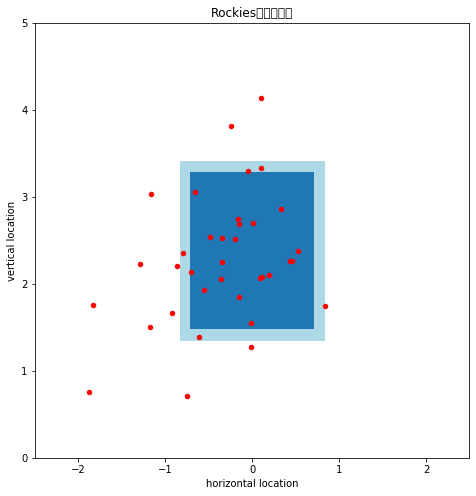

In [57]:
#Rockiesの投球傾向
df = pitchDF[pitchDF['frame']=='bottom'][pitchDF['abIdx']==1]

ax1 = df.plot(kind='scatter', x='px', y='pz', marker='o', color='red', figsize=[8,8], ylim=[0,4], xlim=[-2,2])
ax1.set_xlabel('horizontal location')
ax1.set_ylabel('vertical location')
ax1.set_title('Rockiesの初球傾向')
ax1.set_aspect(aspect=1)

platewidthInFeet = 17 / 12
expandedPlateInFeet = 20 / 12
szTop = df['szTop'].iloc[0]
szBottom = df['szBottom'].iloc[0]
szHeightInFeet = szTop - szBottom
ballInFeet = 3 / 12
halfBallInFeet = ballInFeet / 2

outrect = ax1.add_patch(patches.Rectangle((expandedPlateInFeet/-2, szBottom - halfBallInFeet),expandedPlateInFeet, szHeightInFeet + ballInFeet, color='lightblue'))
rect = ax1.add_patch(patches.Rectangle((platewidthInFeet/-2, szBottom), platewidthInFeet, szHeightInFeet))
outrect.zorder=-2 
rect.zorder=-1 

plt.ylim(0, 5)
plt.xlim(-2.5, 2.5)
plt.show()

In [59]:
#Clayton Kershawの球速変化
df = pitchDF[pitchDF['frame']=='top']
speed = df['speed']
print('平均球速：{}'.format(sum(speed) / len(speed)))
print('最速：{}'.format(max(speed)))
print('最遅：{}'.format(min(speed)))
print('緩急差：{}'.format(max(speed) - min(speed)))

平均球速：87.88504672897201
最速：95.0
最遅：72.4
緩急差：22.599999999999994


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 29699 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36895 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22793 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12398 missing from c

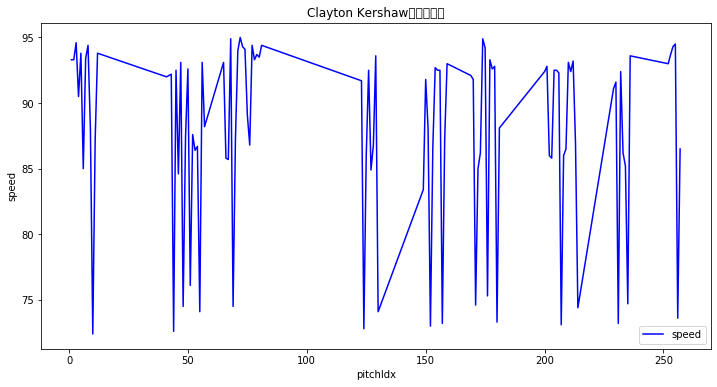

In [61]:
ax = df.plot(x='pitchIdx', y='speed', color='blue', figsize=[12,6])
ax.set_ylabel('speed')
ax.set_title('Clayton Kershawの球速変化')
plt.savefig('pitch_rockies_speed.png')
plt.show()

In [63]:
df = pitchDF[pitchDF['frame']=='bottom']
speed = df['speed']
print('平均球速：{}'.format(sum(speed) / len(speed)))
print('最速：{}'.format(max(speed)))
print('最遅：{}'.format(min(speed)))
print('緩急差：{}'.format(max(speed) - min(speed)))

平均球速：89.13599999999998
最速：96.3
最遅：71.8
緩急差：24.5


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 29699 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36895 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22793 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12398 missing from c

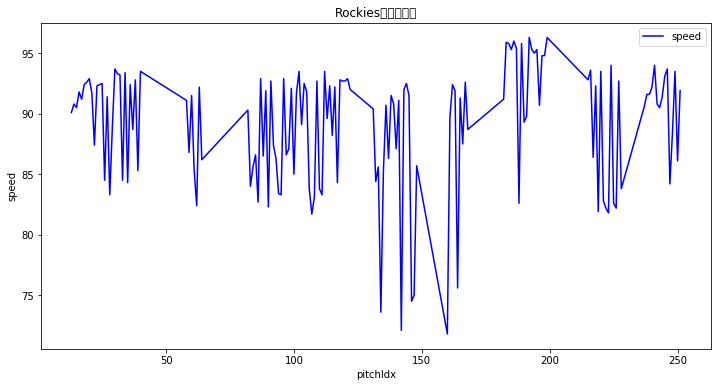

In [64]:
ax = df.plot(x='pitchIdx', y='speed', color='blue', figsize=[12,6])
ax.set_ylabel('speed')
ax.set_title('Rockiesの球速変化')
plt.savefig('pitch_rockies_speed.png')
plt.show()

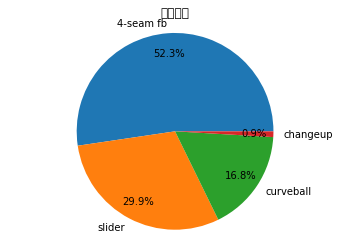

In [73]:
df = pitchDF[pitchDF['frame']== 'top']
df['pitchtype'].value_counts().plot(kind='pie',autopct="%.1f%%", pctdistance=0.8)
plt.axis('equal')
plt.axis('off')
plt.title('球種割合')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 32080 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26524 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 32080 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 26524 missing from curre

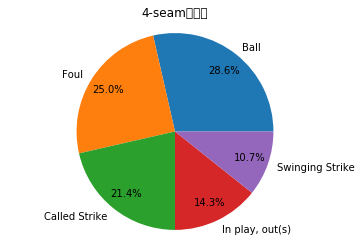

In [75]:
df = pitchDF[(pitchDF['pitchtype']=='4-seam fb') & (pitchDF['frame']=='top')]

df['des'].value_counts().plot(kind='pie',autopct="%.1f%%", pctdistance=0.8)
plt.axis('equal')
plt.axis('off')
plt.title('4-seamの結果')
plt.show()

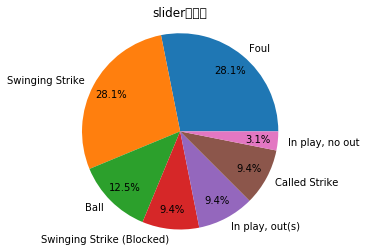

In [78]:
df = pitchDF.loc[(pitchDF['pitchtype']=='slider') & (pitchDF['frame']=='top')]

df['des'].value_counts().plot(kind='pie', autopct="%.1f%%", pctdistance=0.8)
plt.axis('equal')
plt.axis('off')
plt.title('sliderの結果')
plt.show()

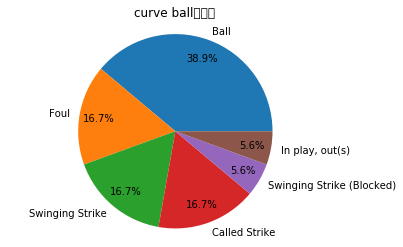

In [80]:
df = pitchDF[(pitchDF['pitchtype']=='curveball') & (pitchDF['frame']=='top')]

df['des'].value_counts().plot(kind='pie', autopct='%.1f%%', pctdistance=0.8)
plt.axis('equal')
plt.axis('off')
plt.title('curve ballの結果')
plt.show()

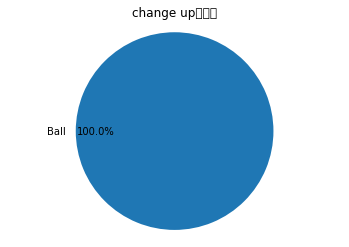

In [81]:
df = pitchDF[(pitchDF['pitchtype']=='changeup') & (pitchDF['frame']=='top')]

df['des'].value_counts().plot(kind='pie', autopct='%.1f%%', pctdistance=0.8)
plt.axis('equal')
plt.axis('off')
plt.title('change upの結果')
plt.show()

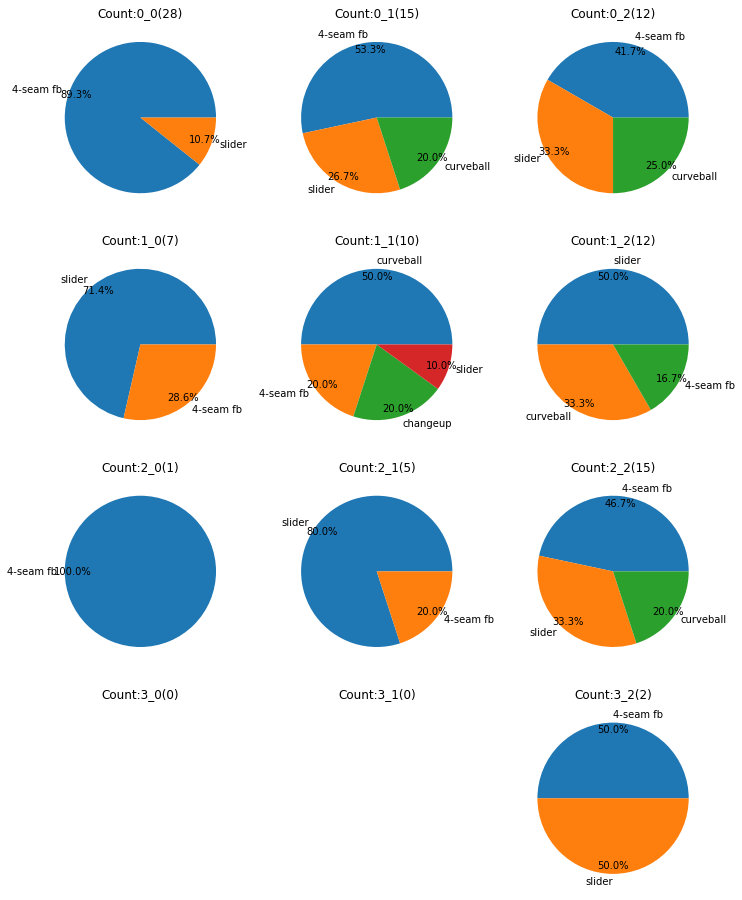

In [89]:
#カウント別配球
titleList = []
dataList = []

fig, axes = plt.subplots(4,3, figsize=(12,16))

axes

for b in range(4):
    for s in range(3):
        df = pitchDF[(pitchDF['ballCount']==b) & (pitchDF['strikeCount']==s) & (pitchDF['frame']=='top')]
        title = 'Count:' + str(b) + '_' + str(s) + '(' + str(len(df)) + ')'
        titleList.append(title)
        dataList.append(df)

for i, ax in enumerate(axes.flatten()):
    x = dataList[i].pitchtype.value_counts()
    l = dataList[i].pitchtype.unique()
    
    ax.pie(x, autopct='%.1f%%', pctdistance=0.9, labels=l)
    ax.set_title(titleList[i])
plt.show()

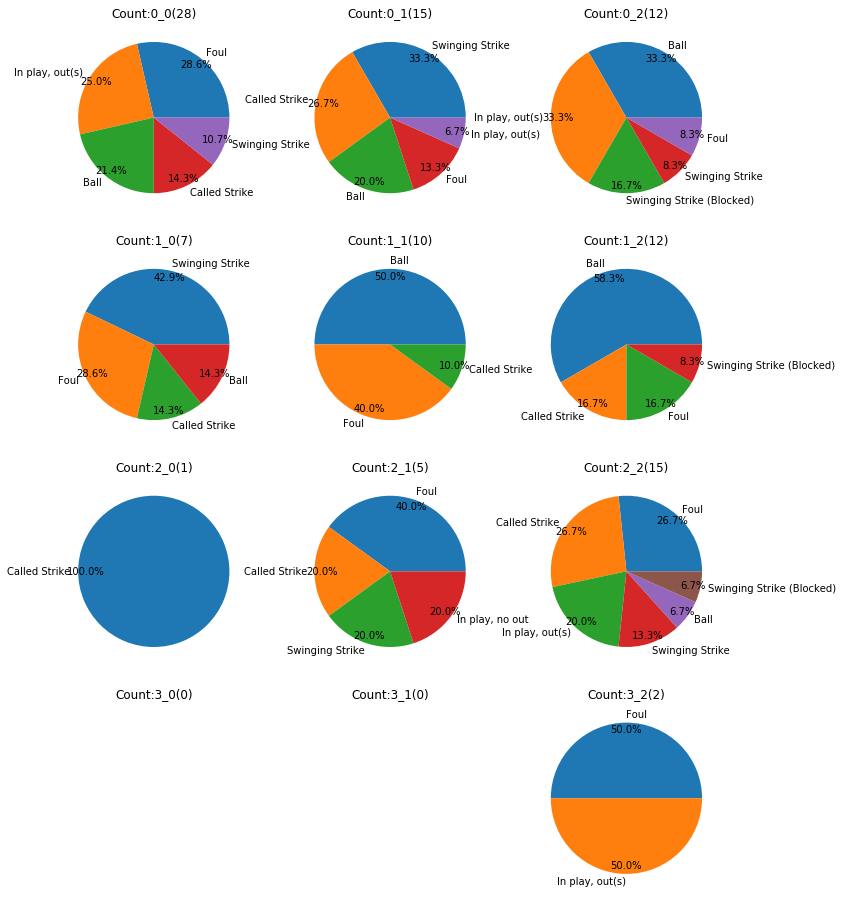

In [90]:
#カウント別結果
titleList = []
dataList = []

fig, axes = plt.subplots(4,3, figsize=(12,16))

axes

for b in range(4):
    for s in range(3):
        df = pitchDF[(pitchDF['ballCount']==b) & (pitchDF['strikeCount']==s) & (pitchDF['frame']=='top')]
        title = 'Count:' + str(b) + '_' + str(s) + '(' + str(len(df)) + ')'
        titleList.append(title)
        dataList.append(df)

for i, ax in enumerate(axes.flatten()):
    x = dataList[i].des.value_counts()
    l = dataList[i].des.unique()
    
    ax.pie(x, autopct='%.1f%%', pctdistance=0.9, labels=l)
    ax.set_title(titleList[i])
plt.show()